In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline
import caffe
import os

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

local_model_path = '../models'
local_net_path = '../net/tracking_img'
local_data_path = '../data_flow'
deploy_proto = os.path.join(local_net_path, 'deploy.prototxt')
mean_data = os.path.join(local_data_path, 'ratsi_mean_full.binaryproto')

In [86]:
# retrieve a model from the server
# model_file = 'caffe_rtracker_iter_6000.caffemodel'
model_file = 'tracking_img_iter_2000.caffemodel'

# os.system("scp dijkstra:rbr_cnn/rtracker_caffe/models/{} {}".format(model_file, local_model_path))

local_model_file = os.path.join(local_model_path, model_file)
if os.path.isfile(local_model_file):
    print 'Model found.'
else:
    print 'Could not locate model.'

Model found.


In [87]:
# load the model
caffe.set_mode_cpu()

model_def = deploy_proto
model_weights = local_model_file

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [47]:
# load the mean image for subtraction
blob = caffe.proto.caffe_pb2.BlobProto()
mudata = open( mean_data , 'rb' ).read()
blob.ParseFromString(mudata)
mu = np.array( caffe.io.blobproto_to_array(blob) )

mu = mu.mean(-1).mean(-1).mean(-1)  # average over pixels to obtain the mean pixel value
print 'mean-subtracted values:', zip('G', mu)

IOError: [Errno 2] No such file or directory: '../data_flow/ratsi_mean_full.binaryproto'

In [94]:
# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

mu = np.asarray([115, 115, 115])/255.
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
# transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
# transformer.set_channel_swap('data', None)  

In [61]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
# net.blobs['data'].reshape(1, 256, 256, 1)  # image size is 227x227

In [96]:
transformed_image.max()

0.32099709

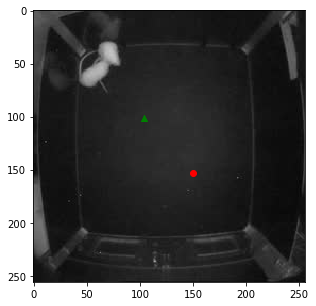

In [100]:
image = caffe.io.load_image('/home/malte/datasets/RatSI/video_frames/Observation04/frame_00009010.jpg', color=True)
transformed_image = transformer.preprocess('data', image)

# fig, axs = plt.subplots(1, 1, figsize=(5,5))
fig = plt.figure(figsize=(5,5))
plt.imshow(image.squeeze())
ax = plt.gca()
# axs[1].imshow(transformed_image)


# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()
output_pos = output['fc8_tracks'][0].reshape((2,2)) * 227. + 127

### plot points
ax.scatter(output_pos[0,0], output_pos[0, 1], c='red', marker='o')
ax.scatter(output_pos[1,0], output_pos[1, 1], c='green', marker='^')
# axs[0].scatter(output_pos[2,0], output_pos[2, 1], c='red', marker='v')
# axs[0].scatter(output_pos[3,0], output_pos[3, 1], c='green', marker='o')
# axs[0].scatter(output_pos[4,0], output_pos[4, 1], c='green', marker='^')
# axs[0].scatter(output_pos[5,0], output_pos[5, 1], c='green', marker='v');

In [102]:
output_pos

array([[ 150.08621216,  153.19494629],
       [ 103.91379547,  100.80506134]], dtype=float32)

---

### Exploring layers

In [103]:
# for each layer, show the output shape
print 'Layer output shapes:'
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)
    
print
print 'Layer parameter shapes:'
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

Layer output shapes:
data	(10, 3, 227, 227)
conv1	(10, 96, 55, 55)
pool1	(10, 96, 27, 27)
norm1	(10, 96, 27, 27)
conv2	(10, 256, 27, 27)
pool2	(10, 256, 13, 13)
norm2	(10, 256, 13, 13)
conv3	(10, 384, 13, 13)
conv4	(10, 384, 13, 13)
conv5	(10, 256, 13, 13)
pool5	(10, 256, 6, 6)
fc6	(10, 4096)
fc7	(10, 4096)
fc8_tracks	(10, 4)

Layer parameter shapes:
conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6	(4096, 9216) (4096,)
fc7	(4096, 4096) (4096,)
fc8_tracks	(4, 4096) (4,)


In [104]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data.squeeze()); plt.axis('off')

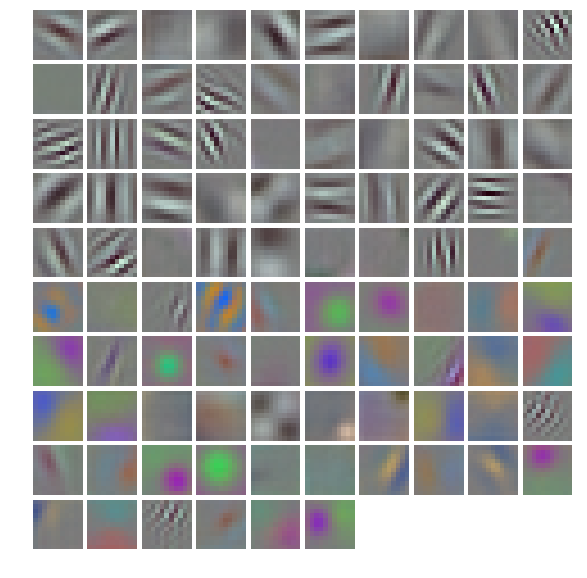

In [105]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

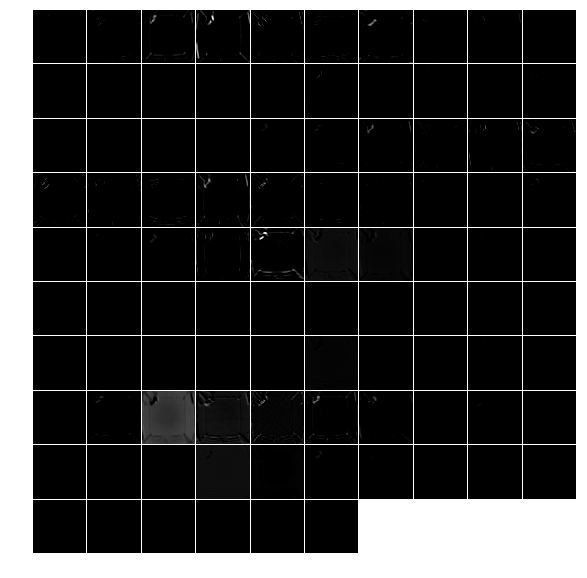

In [106]:
feat = net.blobs['conv1'].data[0, :]
vis_square(feat)

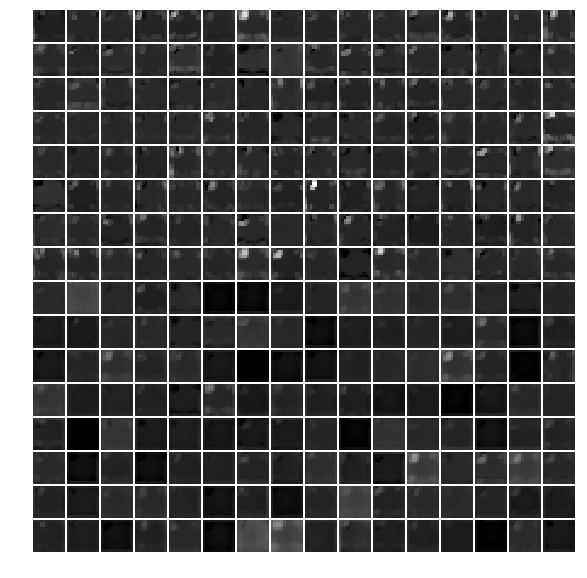

In [107]:
feat = net.blobs['pool2'].data[0]
vis_square(feat)

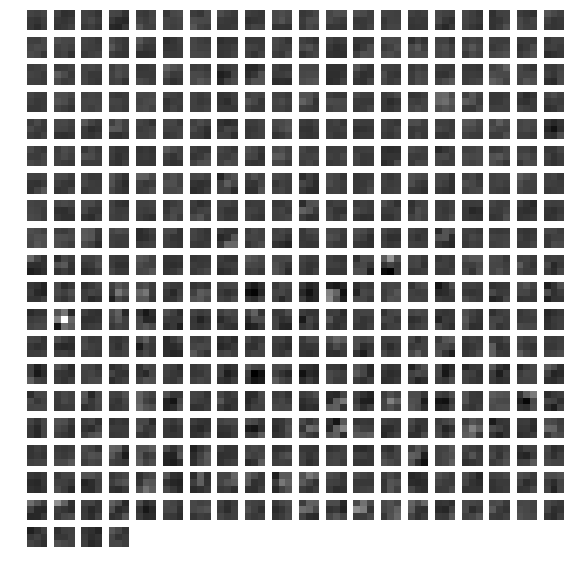

In [108]:
filters = net.params['conv3'][0].data
vis_square(filters.transpose(0, 2, 3, 1)[:,:,:,1])